In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/All.csv"
df = pd.read_csv(path)

### Get a brief look of the dataset

In [4]:
df.head(5)

,textual data,label,time
0,The directors herein present their report and ...,F,20001207
1,Entering the 21st century China has been well...,F,20010330
2,For the six months ended December 31 2000 th...,F,20010423
3,During the period under review the Group cont...,F,20010913
4,Business ReviewInstant Noodle BusinessAccumula...,F,20011115


In [5]:
#get dummy of label
#replace 'F' with 0, 'NF' with 1
df['label'].replace(['F','NF'], [1, 0], inplace=True)

In [51]:
from collections import Counter
Counter(df['label'])

Counter({1: 198, 0: 34650})

### Spliting dataset

In [6]:
#remove stop words
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
stop = stopwords.words('english')
df['textual data'] = df['textual data'].fillna("")
df['textual data'] = df['textual data'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# train test split (whole dataset)
training_data = df.sample(frac = 0.8, random_state = 42)
testing_data = df.drop(training_data.index)
print("Number of training data: ", training_data.shape[0])
print("Number of test data: ", testing_data.shape[0])

Number of training data:  27878
Number of test data:  6970


In [8]:
# get the cleaning train test textual data and label
strings = "[!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n]"
training_text = training_data["textual data"]
training_text.str.lower().replace(strings, "")
training_label = np.array(training_data["label"])

test_text = testing_data["textual data"]
test_text.str.lower().replace(strings, "")
test_label = np.array(testing_data['label'])

### Oversampling to reduce the imbalance of "F" and "NF"

In [9]:
training_text = np.expand_dims(training_text, axis = 1)

In [10]:
Counter(training_label)

Counter({0: 27722, 1: 156})

In [11]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
training_text, training_label = ros.fit_resample(training_text, training_label)

In [12]:
Counter(training_label)

Counter({0: 27722, 1: 27722})

In [13]:
training_text = training_text.flatten()

In [14]:
vocab_size = 20000
max_length = 150
trunc_type = 'post'
oov_tok = "<OOV>"

# generate the word index dictionary from the training sentences only
# then generate and pad both the training sequences and the test sequences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(training_text)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_text)
training_padded = pad_sequences(training_sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_text)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

### 1. Simple model with embedding layer

In [15]:
# 32 in the Embedding constructor means each word will be represented as a 32-element vector
model = Sequential([layers.Embedding(vocab_size, 32, input_length=max_length),
                    # insert layer for model building
                    layers.Flatten(),
                    layers.Dense(6, activation='relu'),
                    layers.Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['AUC'])

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 32)           320000    
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 6)                 23046     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 343,053
Trainable params: 343,053
Non-trainable params: 0
_________________________________________________________________


In [16]:
embeddingmodel_output = model.fit(training_padded, training_label, epochs = 10, validation_data=(testing_padded, test_label))

Epoch 1/10
1733/1733 [==============================] - 11s 5ms/step - loss: 0.0350 - auc: 0.9998 - val_loss: 0.0612 - val_auc: 0.5112
Epoch 2/10
1733/1733 [==============================] - 8s 5ms/step - loss: 3.5481e-04 - auc: 1.0000 - val_loss: 0.0691 - val_auc: 0.4998
Epoch 3/10
1733/1733 [==============================] - 8s 5ms/step - loss: 0.0013 - auc: 1.0000 - val_loss: 0.0757 - val_auc: 0.4999
Epoch 4/10
1733/1733 [==============================] - 8s 5ms/step - loss: 0.0015 - auc: 1.0000 - val_loss: 0.0829 - val_auc: 0.4999
Epoch 5/10
1733/1733 [==============================] - 8s 5ms/step - loss: 0.0010 - auc: 1.0000 - val_loss: 0.0894 - val_auc: 0.5000
Epoch 6/10
1733/1733 [==============================] - 8s 5ms/step - loss: 7.1128e-04 - auc: 1.0000 - val_loss: 0.0959 - val_auc: 0.5000
Epoch 7/10
1733/1733 [==============================] - 8s 5ms/step - loss: 5.1043e-04 - auc: 1.0000 - val_loss: 0.1017 - val_auc: 0.5000
Epoch 8/10
1733/1733 [===========================

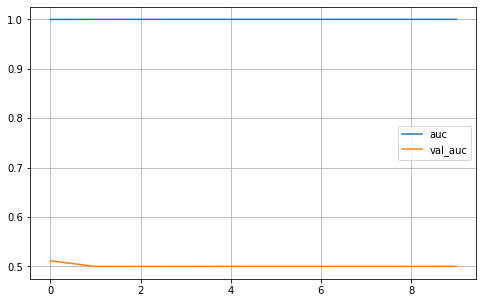

In [17]:
import matplotlib.pyplot as plt
metric_df = pd.DataFrame(embeddingmodel_output.history)
metric_df[['auc','val_auc']].plot(figsize = (8,5))
plt.grid(True)

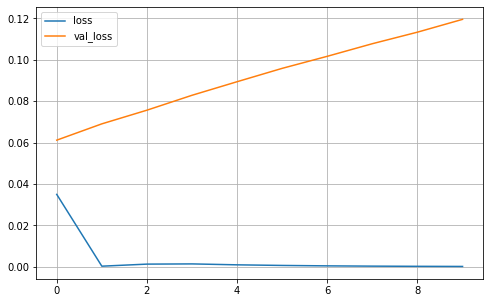

In [18]:
metric_df = pd.DataFrame(embeddingmodel_output.history)
metric_df[['loss','val_loss']].plot(figsize = (8,5))
plt.grid(True)

### 2. SimpleRNN model

In [35]:
# hyperparameters
embedding_dim = 150
state_dim = 64
dense_dim = 32

# model definition
model_vanillaRNN = Sequential([layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                            layers.Bidirectional(layers.SimpleRNN(state_dim)),
                            layers.Dense(dense_dim, activation='relu'),
                            layers.Dense(1, activation='sigmoid')], name="vanilla")

# set the training parameters
model_vanillaRNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

# print the model summary
model_vanillaRNN.summary()

Model: "vanilla"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 120, 150)          1500000   
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              27520     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 32)                4128      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,531,681
Trainable params: 1,531,681
Non-trainable params: 0
_________________________________________________________________


In [36]:
modelRNN_output = model_vanillaRNN.fit(training_padded, training_label, batch_size=256, epochs=10, validation_data=(testing_padded, test_label))

Epoch 1/10
217/217 [==============================] - 62s 276ms/step - loss: 0.0413 - auc: 0.9995 - val_loss: 0.0478 - val_auc: 0.5103
Epoch 2/10
217/217 [==============================] - 58s 267ms/step - loss: 6.3163e-04 - auc: 1.0000 - val_loss: 0.0564 - val_auc: 0.5118
Epoch 3/10
217/217 [==============================] - 57s 262ms/step - loss: 2.3393e-04 - auc: 1.0000 - val_loss: 0.0615 - val_auc: 0.4999
Epoch 4/10
217/217 [==============================] - 56s 260ms/step - loss: 4.1847e-04 - auc: 1.0000 - val_loss: 0.0563 - val_auc: 0.5143
Epoch 5/10
217/217 [==============================] - 56s 258ms/step - loss: 0.0016 - auc: 1.0000 - val_loss: 0.0723 - val_auc: 0.5113
Epoch 6/10
217/217 [==============================] - 56s 258ms/step - loss: 2.3130e-04 - auc: 1.0000 - val_loss: 0.0733 - val_auc: 0.5108
Epoch 7/10
217/217 [==============================] - 56s 260ms/step - loss: 1.7509e-04 - auc: 1.0000 - val_loss: 0.0780 - val_auc: 0.5115
Epoch 8/10
217/217 [===============

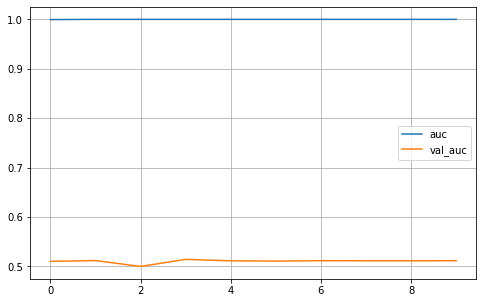

In [37]:
metric_df = pd.DataFrame(modelRNN_output.history)
metric_df[['auc','val_auc']].plot(figsize = (8,5))
plt.grid(True)

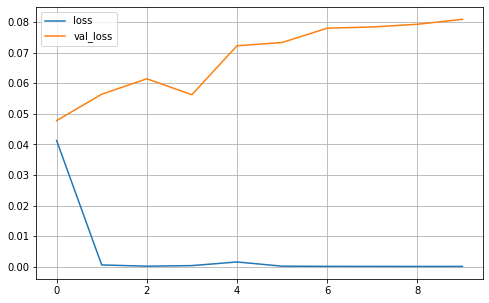

In [38]:
metric_df = pd.DataFrame(modelRNN_output.history)
metric_df[['loss','val_loss']].plot(figsize = (8,5))
plt.grid(True)

### 3. LSTM model

In [39]:
# hyperparameters
embedding_dim = 150
state_dim = 64
dense_dim = 32

# model definition
model_lstm = Sequential([layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                         layers.Bidirectional(layers.LSTM(state_dim)),
                         layers.Dropout(rate = 0.2),
                         layers.Dense(dense_dim, kernel_regularizer = keras.regularizers.l2(l2 = 0.1), activation='relu'),
                         layers.BatchNormalization(),
                         layers.Dropout(rate = 0.2),
                         layers.Dense(1, activation='sigmoid')], name="lstm")

# set the training parameters
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

# print the model summary
model_lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 120, 150)          1500000   
                                                                 
 bidirectional_6 (Bidirectio  (None, 128)              110080    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 32)                4128      
                                                                 
 batch_normalization_2 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 32)                0      

In [40]:
model_lstm_output = model_lstm.fit(training_padded, training_label, batch_size=256, epochs=10, validation_data=(testing_padded, test_label))

Epoch 1/10
217/217 [==============================] - 10s 28ms/step - loss: 1.3813 - auc: 0.9992 - val_loss: 0.4160 - val_auc: 0.5068
Epoch 2/10
217/217 [==============================] - 5s 25ms/step - loss: 0.0193 - auc: 1.0000 - val_loss: 0.1317 - val_auc: 0.4888
Epoch 3/10
217/217 [==============================] - 5s 25ms/step - loss: 0.0020 - auc: 1.0000 - val_loss: 0.0447 - val_auc: 0.4931
Epoch 4/10
217/217 [==============================] - 5s 25ms/step - loss: 0.0020 - auc: 0.9999 - val_loss: 0.0719 - val_auc: 0.4978
Epoch 5/10
217/217 [==============================] - 5s 24ms/step - loss: 0.0016 - auc: 1.0000 - val_loss: 0.0573 - val_auc: 0.4973
Epoch 6/10
217/217 [==============================] - 5s 24ms/step - loss: 0.0047 - auc: 0.9999 - val_loss: 0.0738 - val_auc: 0.5078
Epoch 7/10
217/217 [==============================] - 5s 25ms/step - loss: 0.0028 - auc: 0.9999 - val_loss: 0.0867 - val_auc: 0.4996
Epoch 8/10
217/217 [==============================] - 5s 25ms/step -

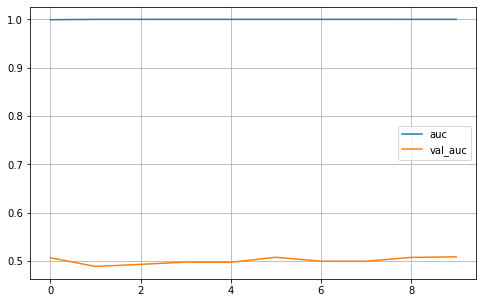

In [41]:
metric_df = pd.DataFrame(model_lstm_output.history)
metric_df[['auc','val_auc']].plot(figsize = (8,5))
plt.grid(True)

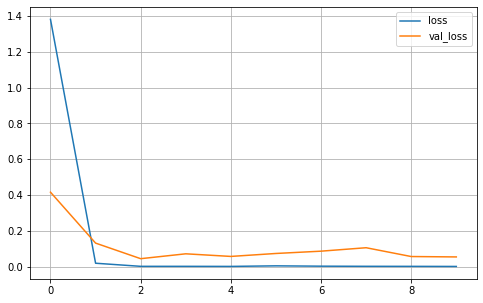

In [42]:
metric_df = pd.DataFrame(model_lstm_output.history)
metric_df[['loss','val_loss']].plot(figsize = (8,5))
plt.grid(True)

### 4. GRU Model

In [43]:
embedding_dim = 150
state_dim = 64
dense_dim = 32

# model definition
model_gru = Sequential([layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                         layers.Bidirectional(layers.GRU(state_dim)),
                         layers.Dense(dense_dim, activation='relu'),
                         layers.Dense(1, activation='sigmoid')], name="gru")

# set the training parameters
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

# print the model summary
model_gru.summary()

Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 120, 150)          1500000   
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              82944     
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 32)                4128      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,587,105
Trainable params: 1,587,105
Non-trainable params: 0
_________________________________________________________________


In [44]:
model_gru_output = model_gru.fit(training_padded, training_label, batch_size=256, epochs=10, validation_data=(testing_padded, test_label))

Epoch 1/10
217/217 [==============================] - 8s 25ms/step - loss: 0.0883 - auc: 0.9977 - val_loss: 0.0941 - val_auc: 0.4978
Epoch 2/10
217/217 [==============================] - 5s 21ms/step - loss: 0.0010 - auc: 0.9999 - val_loss: 0.0908 - val_auc: 0.4994
Epoch 3/10
217/217 [==============================] - 5s 21ms/step - loss: 0.0013 - auc: 0.9999 - val_loss: 0.0959 - val_auc: 0.4984
Epoch 4/10
217/217 [==============================] - 5s 21ms/step - loss: 4.4347e-04 - auc: 1.0000 - val_loss: 0.1040 - val_auc: 0.4994
Epoch 5/10
217/217 [==============================] - 4s 21ms/step - loss: 2.2291e-04 - auc: 1.0000 - val_loss: 0.0991 - val_auc: 0.5111
Epoch 6/10
217/217 [==============================] - 5s 21ms/step - loss: 2.0208e-04 - auc: 1.0000 - val_loss: 0.1043 - val_auc: 0.4994
Epoch 7/10
217/217 [==============================] - 5s 22ms/step - loss: 1.5942e-04 - auc: 1.0000 - val_loss: 0.1032 - val_auc: 0.5110
Epoch 8/10
217/217 [==============================] -

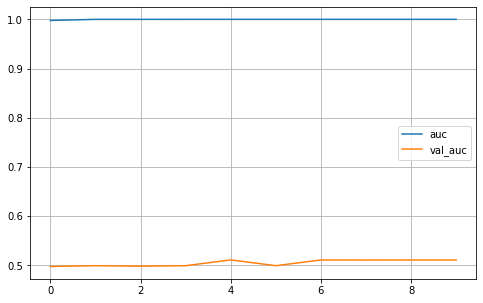

In [45]:
metric_df = pd.DataFrame(model_gru_output.history)
metric_df[['auc','val_auc']].plot(figsize = (8,5))
plt.grid(True)

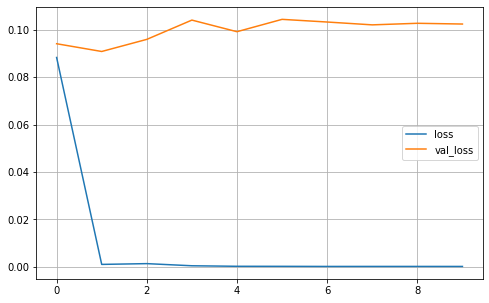

In [46]:
metric_df = pd.DataFrame(model_gru_output.history)
metric_df[['loss','val_loss']].plot(figsize = (8,5))
plt.grid(True)

### 5. Multi-layer (LSTM) RNNs

In [47]:
embedding_dim = 150
state_dim = 64
dense_dim = 32


# model definition
model_multi_layer = Sequential([layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                                layers.Bidirectional(layers.LSTM(state_dim, return_sequences=True)),
                                layers.BatchNormalization(),
                                layers.Dropout(rate=0.2),
                                layers.Bidirectional(layers.LSTM(state_dim)),
                                layers.Dropout(rate=0.2),
                                layers.Dense(dense_dim, kernel_regularizer = keras.regularizers.l2(l2 = 0.01), activation='relu'),
                                layers.Dense(1, activation='sigmoid')], name="multi_layer")

# set the training parameters
model_multi_layer.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

# print the model summary
model_multi_layer.summary()

Model: "multi_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 120, 150)          1500000   
                                                                 
 bidirectional_8 (Bidirectio  (None, 120, 128)         110080    
 nal)                                                            
                                                                 
 batch_normalization_3 (Batc  (None, 120, 128)         512       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 120, 128)          0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                       

In [48]:
model_multilayer_output = model_multi_layer.fit(training_padded, training_label, batch_size=256, epochs=10, validation_data=(testing_padded, test_label))

Epoch 1/10
217/217 [==============================] - 18s 50ms/step - loss: 0.1865 - auc: 0.9994 - val_loss: 0.0652 - val_auc: 0.5619
Epoch 2/10
217/217 [==============================] - 9s 43ms/step - loss: 0.0130 - auc: 0.9999 - val_loss: 0.6405 - val_auc: 0.5990
Epoch 3/10
217/217 [==============================] - 9s 43ms/step - loss: 0.0135 - auc: 1.0000 - val_loss: 0.0483 - val_auc: 0.5205
Epoch 4/10
217/217 [==============================] - 9s 43ms/step - loss: 0.0049 - auc: 1.0000 - val_loss: 0.0470 - val_auc: 0.5186
Epoch 5/10
217/217 [==============================] - 9s 44ms/step - loss: 0.0038 - auc: 1.0000 - val_loss: 0.0479 - val_auc: 0.5091
Epoch 6/10
217/217 [==============================] - 11s 49ms/step - loss: 0.0033 - auc: 1.0000 - val_loss: 0.0480 - val_auc: 0.5092
Epoch 7/10
217/217 [==============================] - 9s 44ms/step - loss: 0.0029 - auc: 1.0000 - val_loss: 0.0493 - val_auc: 0.5103
Epoch 8/10
217/217 [==============================] - 9s 44ms/step 

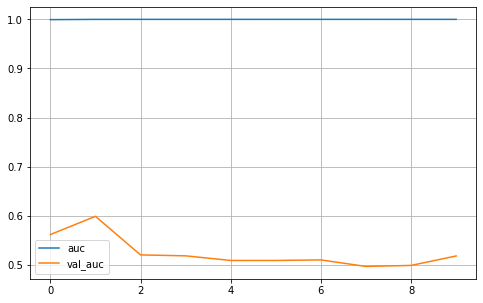

In [49]:
metric_df = pd.DataFrame(model_multilayer_output.history)
metric_df[['auc','val_auc']].plot(figsize = (8,5))
plt.grid(True)

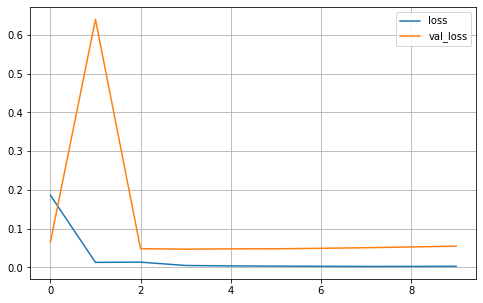

In [50]:
metric_df = pd.DataFrame(model_multilayer_output.history)
metric_df[['loss','val_loss']].plot(figsize = (8,5))
plt.grid(True)